In [1]:
import pandas as pd
from os.path import join, isdir

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from icecream import ic
from src.utils import variant_utils as vu
from glob import glob
from itertools import product
from collections import defaultdict
from tqdm.notebook import tqdm

In [2]:
indir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/"
outdir = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/mt_as_clones"
se_meta = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/gff_A2_black/annotation_clones/se_cells_meta_labels.tsv"


mt_genome="/data/Mito_Trace/data/external/GRCh38_MT_blacklist/chrM.fasta"
#samples = "preB,postB"

## Parameters:
# af thresholds
# coverage threshold
# other_af thresholds
# number of cells / fraction cells
# number of other cells / fraction other cells
af_ts = [0.01, 0.1, 0.4, 0.8,]
oth_af_ts = [0.01, 0.1, 0.4]

cov_ts = [2, 10, 30] # mean coverage at position for cells with the AF
oth_cov_ts = [2, 10, 30]  # mean coverage for cells without AF 

num_cells = [5, 10, 30] # num cells and fraction are for cells with sufficient coverage
oth_num_cells = [0.25, 0.6, 0.8] # fraction is of cells with sufficient coverage

mean_pos_cov = [0, 10] #populatiion average coverage at that position

In [3]:
#samples = samples.split(",")

### Smaller params

In [4]:
don_dirs = [d for d in glob(indir + "/donor*") if isdir(d)]
don_dirs = {int(x.split("donor")[-1]):x for x in don_dirs}
#don_dirs = {x:don_dirs[x] for x in don_dirs if x in range(n_donors)}
don_dirs

{0: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0',
 1: '/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor1'}

In [5]:
# thresholds = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9]
# read_thresh = [2, 10, 25, 50, 100]
# thresholds = [0.1, 0.25]#
# read_thresh = [25, 50]

# thresholds = [t]
# read_thresh=[rt]
# cells_thresh=10
# ref_cells_thresh=500

In [6]:
def load_donor(don_dir):
    vcf = pd.read_csv(join(don_dir, "cellSNP.base.vcf"), sep="\t")
    variants_meta = vcf[["#CHROM", "POS", "REF", "ALT"]]
    variants_meta.index = variants_meta.apply(lambda x: f"{x['POS']}{x['REF'][0]}>{x['ALT']}", axis=1)
    variants_meta = vu.type_of_variants(variants_meta.index)
    variants_meta["ID"] = variants_meta.index
    variants_meta.index = variants_meta.apply(lambda x: f"{x['position']}{x['alt']}", axis=1)
    af = pd.read_csv(join(don_dir, "af.tsv"), sep="\t", index_col=0)
    cov = pd.read_csv(join(don_dir, "dp.tsv"), sep="\t", index_col=0)                   
    cells_meta = pd.read_csv(join(don_dir,"cells_meta.tsv"), sep="\t").set_index("ID")
    ic(cells_meta.shape)
    cells_meta = cells_meta.loc[af.index]
    ic("After filtering on af indices", cells_meta.shape)
    
    variants = set(af.columns)
    return af, cov, cells_meta, variants



In [7]:
af_d = {}
for d in don_dirs: 
    curr_af, curr_cov, curr_cells_meta, curr_variants = load_donor(don_dirs[d])
    if curr_af.shape[0] == 0:
        continue
    curr_cov_name = curr_cov.copy()   
    curr_cov_name.index = "COV-" + curr_cov.index
    curr_af_cov = pd.concat([curr_af, curr_cov_name], verify_integrity=True, sort=False)
    af_d[d] = curr_af
#     full_params_df = full_params.copy()
#     #curr_af_cov.apply(run_per_pos, args=(full_params_df,),expand=True)
#     all_passed_vars = defaultdict(list)
#     params_results = full_params_df.copy()
#     params_results["Variants"] = None


ic| cells_meta.shape: (9023, 6)
ic| 'After filtering on af indices', cells_meta.shape: (9023, 6)
ic| cells_meta.shape: (8275, 6)
ic| 'After filtering on af indices', cells_meta.shape: (8275, 6)


In [8]:
labels_df = pd.read_csv(se_meta,sep="\t").set_index("ID")
print(labels_df.shape)

labels_df = labels_df[~(labels_df["donor"]=='None')]
print(labels_df.shape)
labels_df.head()

(18672, 39)
(16639, 39)


,orig.ident,nCount_ATAC,nFeature_ATAC,total,duplicate,chimeric,unmapped,lowmapq,mitochondrial,passed_filters,...,ATAC_snn_res.0.8,seurat_clusters,nCount_RNA,nFeature_RNA,Row.names,lineage,donor,condition,name,cluster_labels
ID,,,,,,,,,,,,,,,,,,,,,
AAACGAAAGAATCAGT-1_Control,Control,1972,1972,6432,1259,31,19,266,1066,3791,...,6,6,2211,1942,Control_AAACGAAAGAATCAGT-1,4,1,Control,1_4,eosonophil
AAACGAAAGCATACCT-1_Control,Control,2674,2674,11858,1937,51,34,549,3102,6185,...,7,7,3311,2750,Control_AAACGAAAGCATACCT-1,30,1,Control,1_30,MPP/CMP/GMP C
AAACGAAAGCGAGAAA-1_Control,Control,1939,1939,7365,1097,25,27,275,2184,3757,...,7,7,2112,1838,Control_AAACGAAAGCGAGAAA-1,27,0,Control,0_27,MPP/CMP/GMP C
AAACGAAAGTACAGAT-1_Control,Control,862,862,4095,861,16,16,230,771,2201,...,4,4,1441,1317,Control_AAACGAAAGTACAGAT-1,4,0,Control,0_4,erythroid
AAACGAAAGTACAGTA-1_Control,Control,1775,1775,8088,1091,27,27,369,2157,4417,...,6,6,2385,2085,Control_AAACGAAAGTACAGTA-1,21,1,Control,1_21,eosonophil


## Group by cluster_labels and donor and get MT average

In [9]:
def get_mt_mean(curr_df, af_d):
    #print(af_d)
    #print(af_d[0])
    lab, don = curr_df.name
    print(lab, don)
    curr_af = af_d[int(don)]
    return curr_af.loc[curr_df.index].mean(axis=0)
    
lin_mt_af = labels_df.groupby(["cluster_labels", "donor"]).apply(get_mt_mean, af_d)

CLP 0
CLP 1
DC 0
DC 1
MEP 0
MEP 1
MPP/CMP/GMP 0
MPP/CMP/GMP 1
MPP/CMP/GMP B 0
MPP/CMP/GMP B 1
MPP/CMP/GMP C 0
MPP/CMP/GMP C 1
MPP/CMP/GMP D 0
MPP/CMP/GMP D 1
eosonophil 0
eosonophil 1
erythroid 0
erythroid 1
macrophage 0
macrophage 1
meg/erythroid 0
meg/erythroid 1
monocyte 0
monocyte 1
neutrophil 0
neutrophil 1
neutrophil B 0
neutrophil B 1


# Sort variants by variance

In [10]:
from mplh.color_utils import create_color_df_v02

In [11]:
lin_mt_af.reset_index().groupby(["donor"])

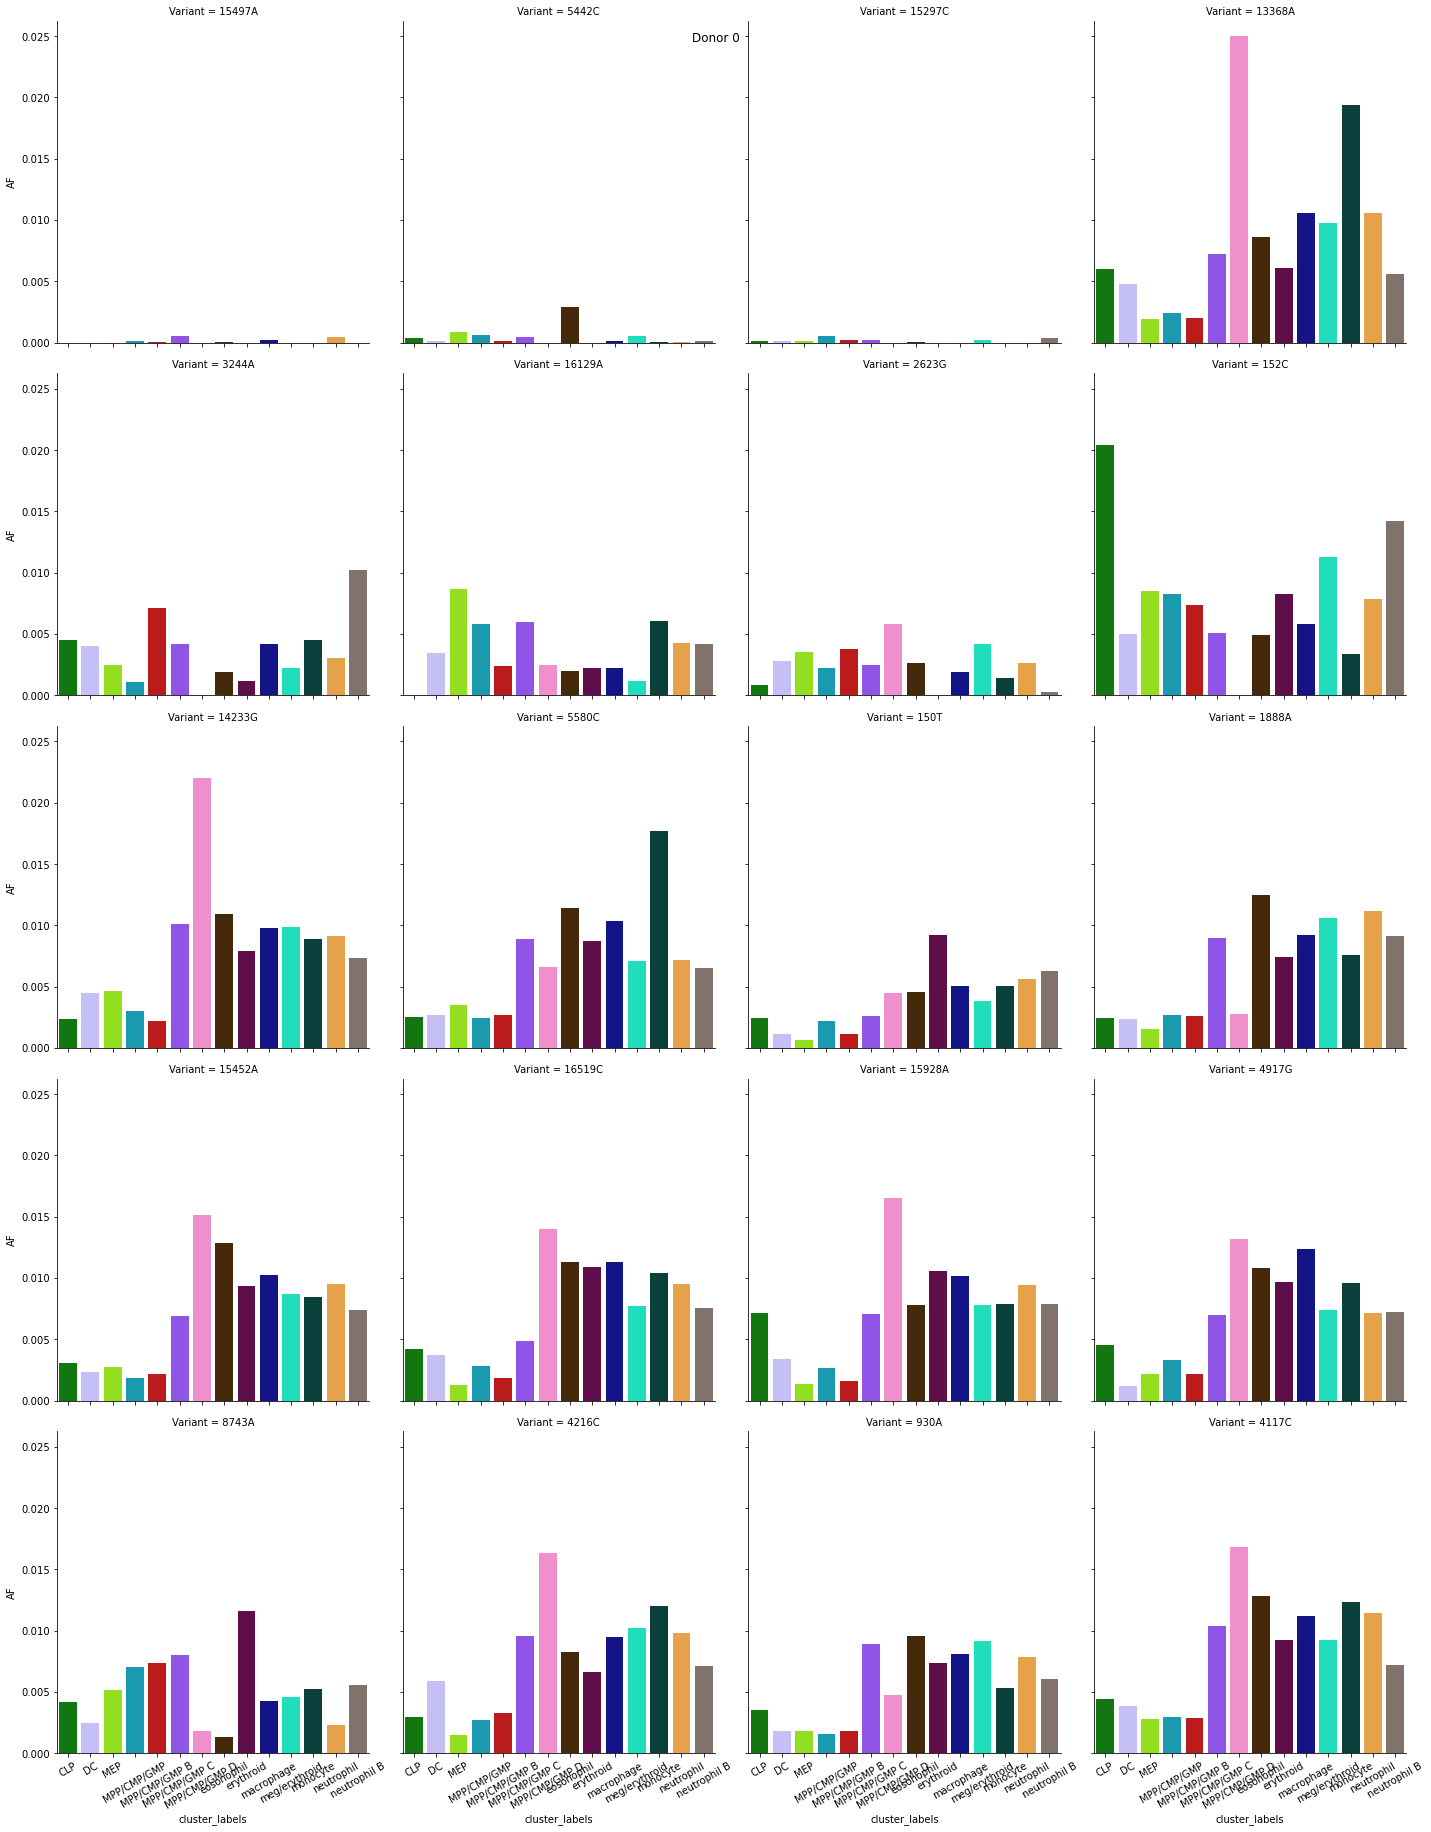

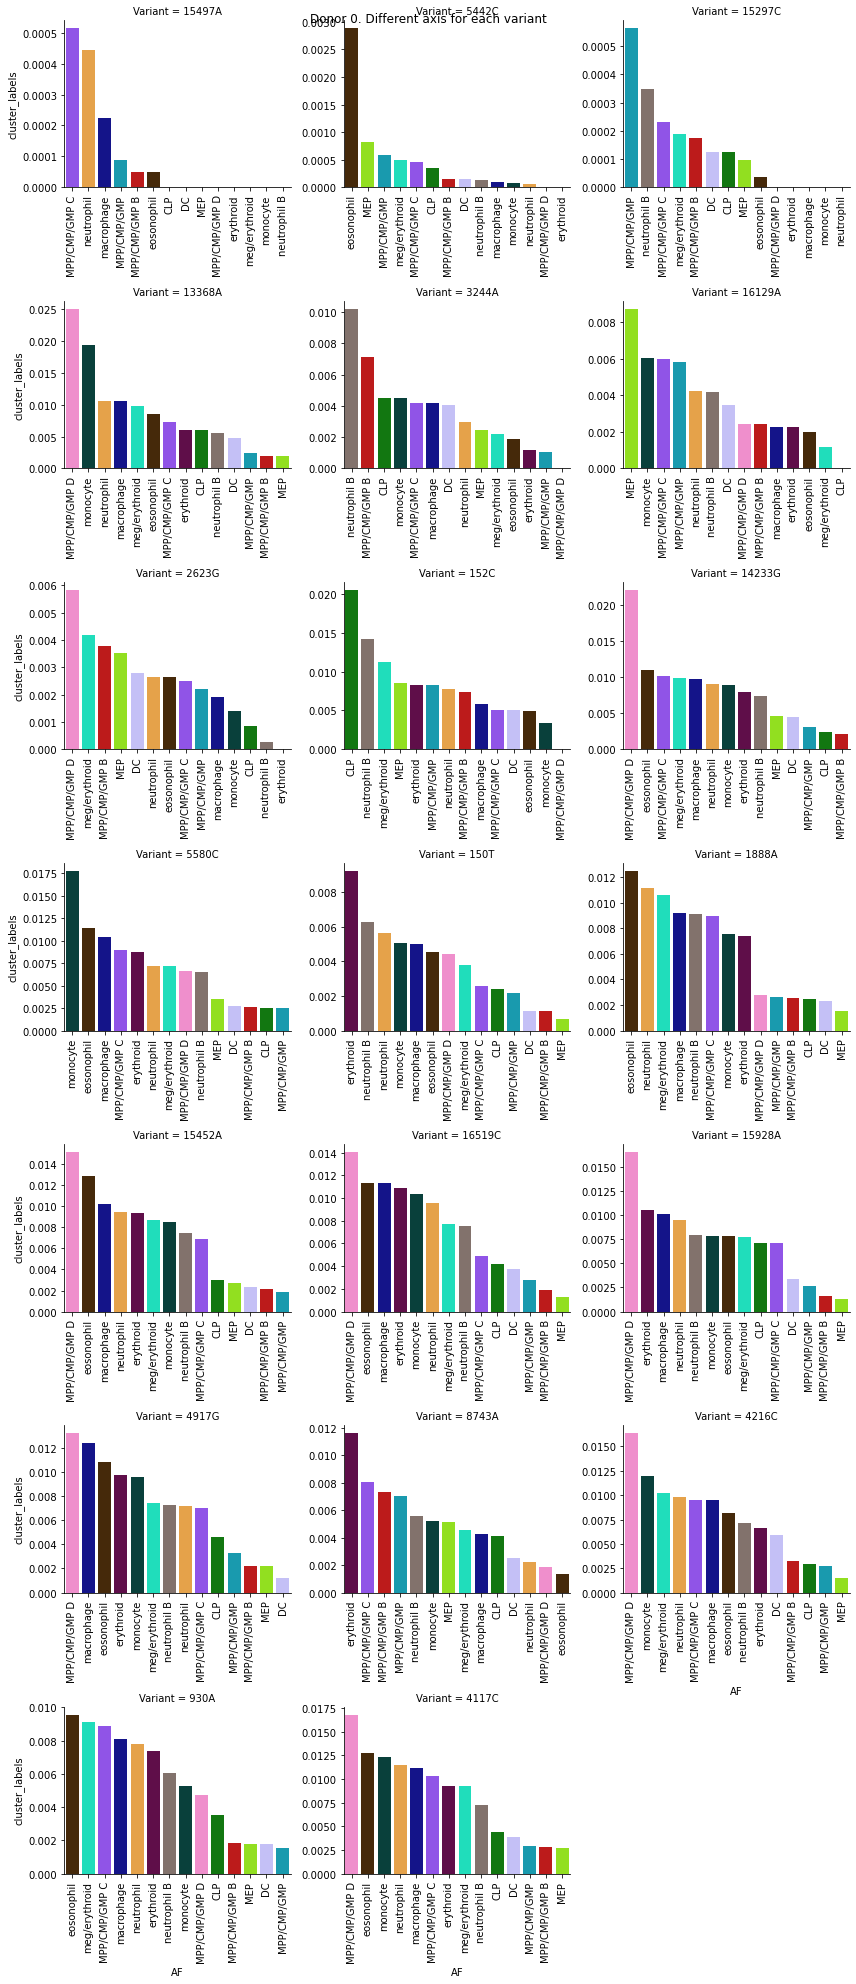

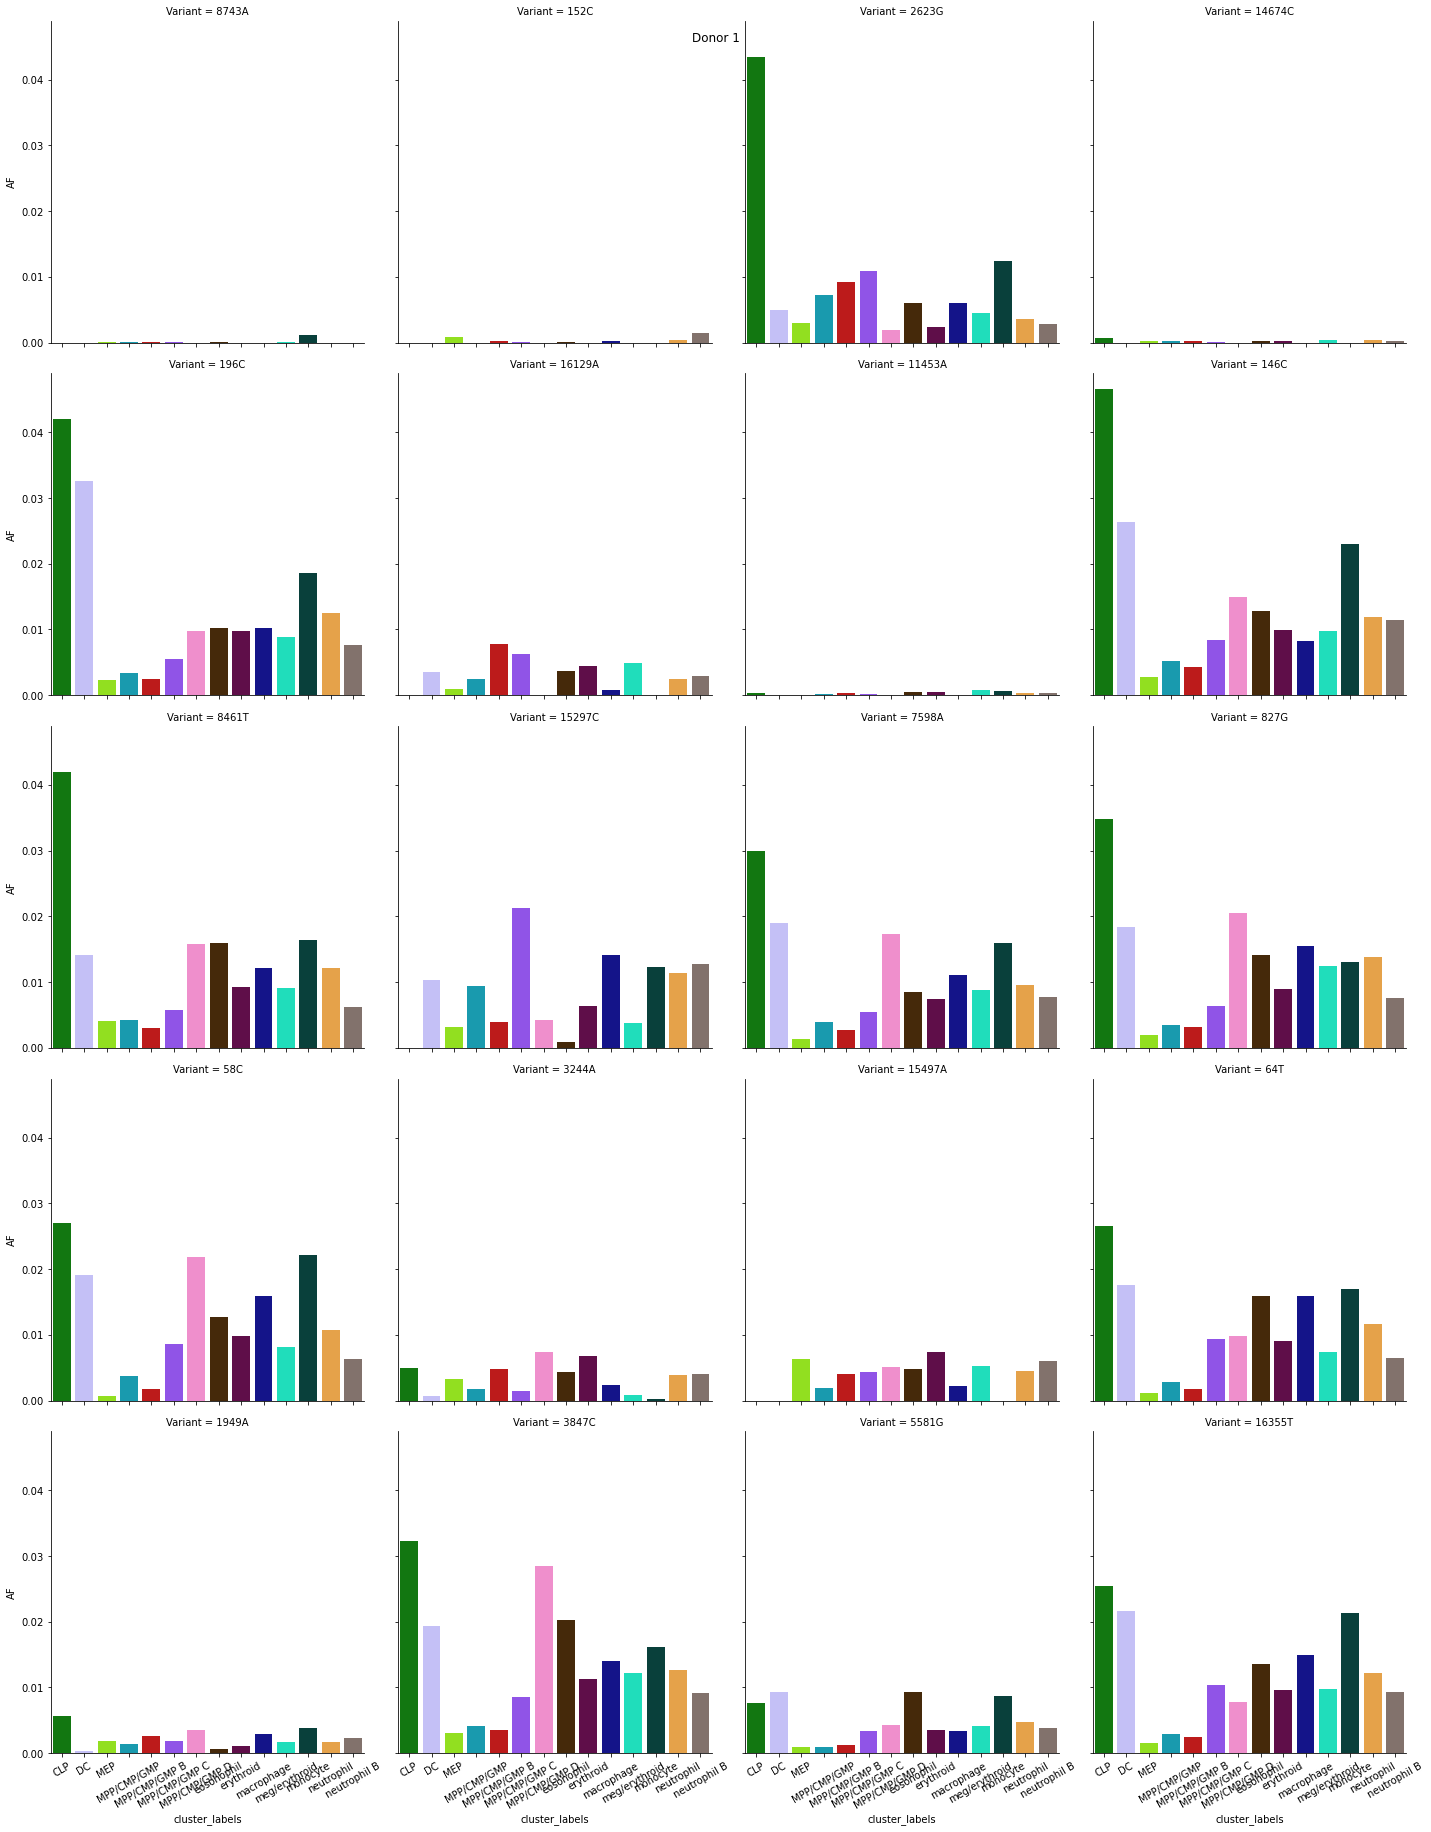

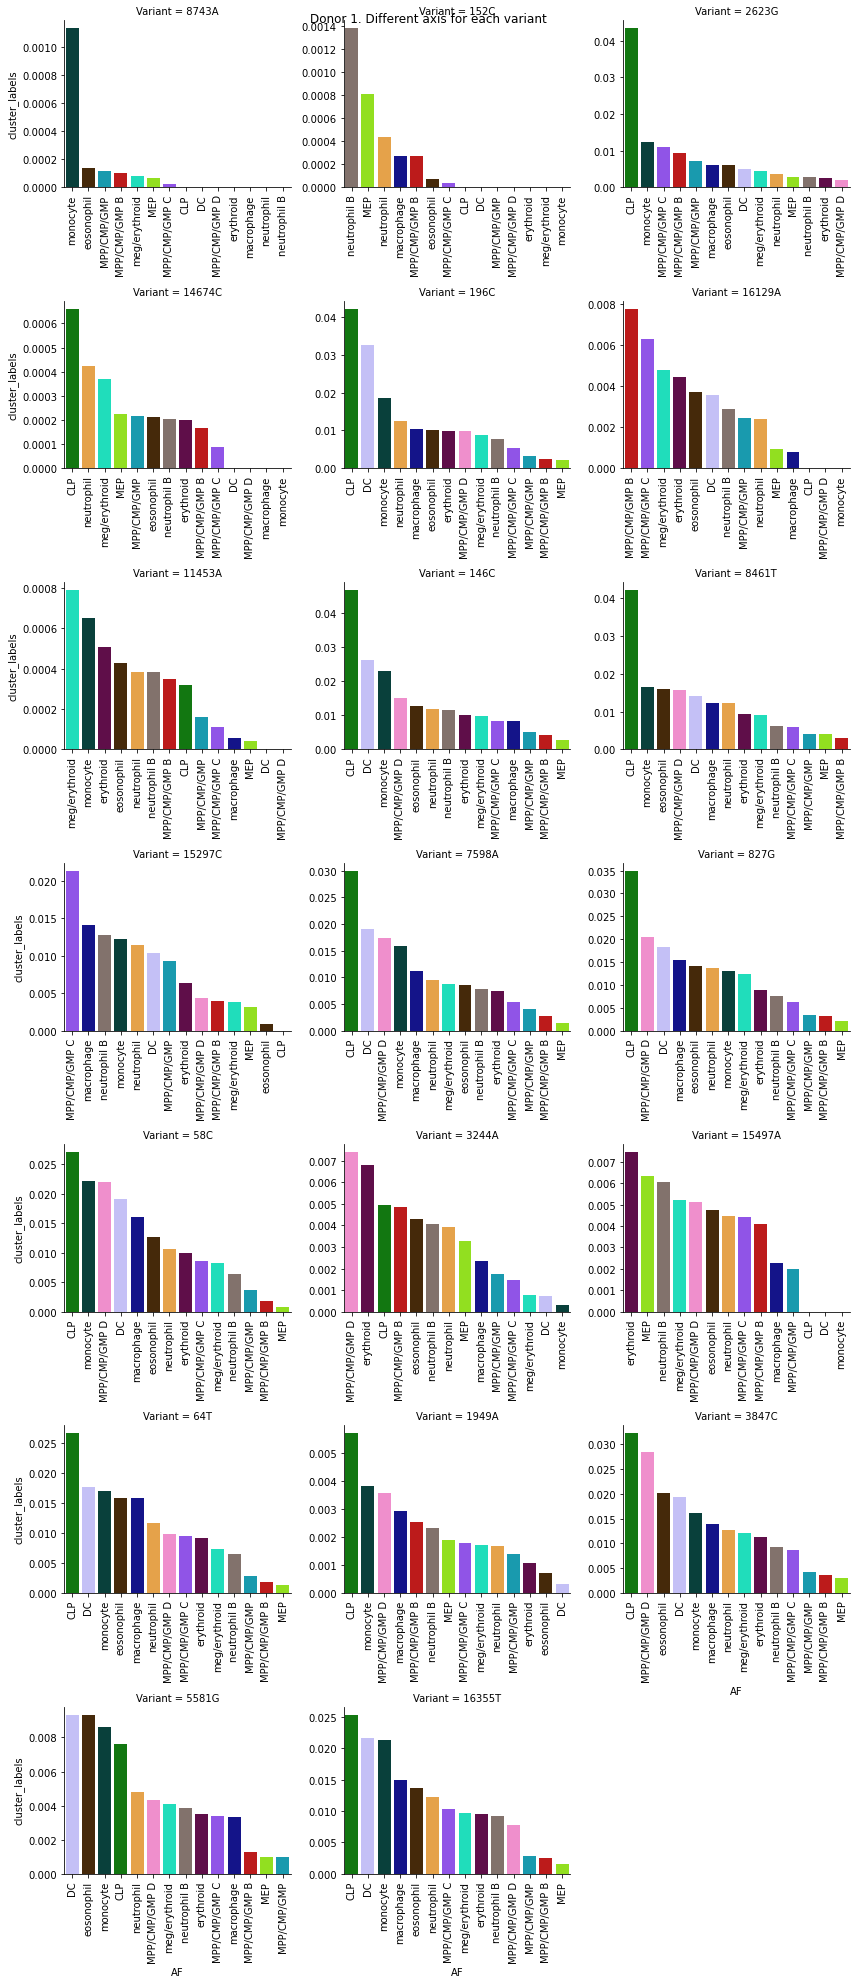

In [34]:
def get_cv(x):
    return np.std(x, ddof=1)/ np.mean(x) * 100



def order_bar(af, cluster_labels, **kwargs):
    df = pd.DataFrame({"AF":af, "clust": cluster_labels}) #, columns=['AF',"clust"])
    order = cluster_labels.loc[af.sort_values(ascending=False).index] #by="AF", ascending=False)["cluster_labels"]
    #print(df)
    #sns.barplot(data=df, y="AF", x="clust", order=order, hue="clust", hue_order=hue_order)
    sns.barplot(y=af, x=cluster_labels, order=order, hue=cluster_labels, palette=color_out[2],dodge=False)#, hue_order=hue_order)
    #plt.xticks(rotation=45)
    return



for curr_don, don_lin_mt_af in lin_mt_af.reset_index().groupby("donor"):
    curr_don_mt = don_lin_mt_af.set_index(["cluster_labels","donor"])
    lin_mt_cv = curr_don_mt.apply(get_cv, axis=0).sort_values(ascending=False)
    curr_don_mt = curr_don_mt.loc[:,lin_mt_cv.index]

    lin_mt_af_w = curr_don_mt.iloc[:,:20].reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="AF")
    #print(lin_mt_af_w)
    hue_order = lin_mt_af_w["cluster_labels"].unique()
    color_out = create_color_df_v02(lin_mt_af_w, col="cluster_labels", clr_type='categorical')


    g = sns.catplot(x="cluster_labels", y="AF", col="Variant", kind='bar', data=lin_mt_af_w, col_wrap=4, 
                    hue_order=hue_order, palette=color_out[2])
    g.set_xticklabels(rotation=30)
    g.fig.suptitle(f"Donor {curr_don}")
    
    
#    g = sns.catplot(x="cluster_labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
 #               sharey=False, sharex=False, hue=None)
    g = sns.FacetGrid(col="Variant", data=lin_mt_af_w, col_wrap=3, sharex=False, sharey=False, 
                      hue_order=hue_order,height=4)
    g.map(order_bar, "AF", "cluster_labels")
    g.set_xticklabels(rotation=90)
    g.fig.suptitle(f"Donor {curr_don}. Different axis for each variant")
    g.fig.tight_layout()

In [35]:
don_lin_mt_af_w

NameError: name 'don_lin_mt_af_w' is not defined

In [20]:
don_lin_mt_af.set_index(["cluster_labels","donor"])

,,10397G,10463C,10559G,10589A,11251G,11453A,11719A,11761T,11812G,13188T,...,750G,7598A,827G,8292A,8461T,8697A,8743A,8860G,930A,9899C
cluster_labels,donor,,,,,,,,,,,,,,,,,,,,,
CLP,0,0.990213,0.003467,0.008459,0.986140,0.003513,0.013625,0.003488,0.993068,0.004536,0.993076,...,0.999752,0.994221,0.995559,0.995833,0.994080,0.008396,0.004138,0.999706,0.003548,0.002459
DC,0,0.996500,0.005691,0.004325,0.992441,0.004339,0.004943,0.005707,0.987844,0.005819,0.994559,...,0.999275,0.990692,0.995056,0.995674,0.993846,0.005820,0.002483,0.999635,0.001791,0.002884
MEP,0,0.996514,0.001350,0.002401,0.996065,0.003958,0.019642,0.002632,0.990183,0.001903,0.995804,...,0.998657,0.995906,0.997445,0.997266,0.996266,0.002420,0.005116,0.998958,0.001796,0.001708
MPP/CMP/GMP,0,0.994140,0.004082,0.004372,0.991648,0.002678,0.020226,0.003048,0.992995,0.003476,0.995322,...,0.998747,0.995180,0.994594,0.995955,0.994845,0.001649,0.007019,0.999534,0.001541,0.001838
MPP/CMP/GMP B,0,0.996648,0.002938,0.002535,0.995626,0.002854,0.018047,0.002017,0.990259,0.002321,0.995636,...,0.999584,0.996303,0.997475,0.996312,0.996442,0.002727,0.007323,0.999561,0.001840,0.001526
MPP/CMP/GMP C,0,0.973025,0.009678,0.008419,0.980666,0.007032,0.016932,0.006235,0.979081,0.007647,0.980475,...,0.997591,0.978463,0.991450,0.984847,0.984679,0.008296,0.008034,0.996118,0.008888,0.007019
MPP/CMP/GMP D,0,0.838826,0.010191,0.012570,0.879690,0.010079,0.027473,0.007926,0.951323,0.010431,0.947284,...,0.972527,0.874921,0.932365,0.915987,0.935269,0.013595,0.001832,0.983516,0.004723,0.009379
eosonophil,0,0.931211,0.009647,0.008023,0.940363,0.011595,0.018664,0.012978,0.956242,0.012381,0.970940,...,0.986263,0.933456,0.961035,0.971684,0.959303,0.010683,0.001324,0.991039,0.009575,0.006028
erythroid,0,0.957702,0.009252,0.006160,0.947681,0.008969,0.021384,0.007295,0.978144,0.008200,0.973408,...,0.993442,0.958773,0.981142,0.981680,0.964218,0.012910,0.011569,0.991169,0.007370,0.006120


In [16]:
for curr_don, don_lin_mt_af in lin_mt_af.reset_index().groupby("donor"):
    print(curr_don)
    break

0


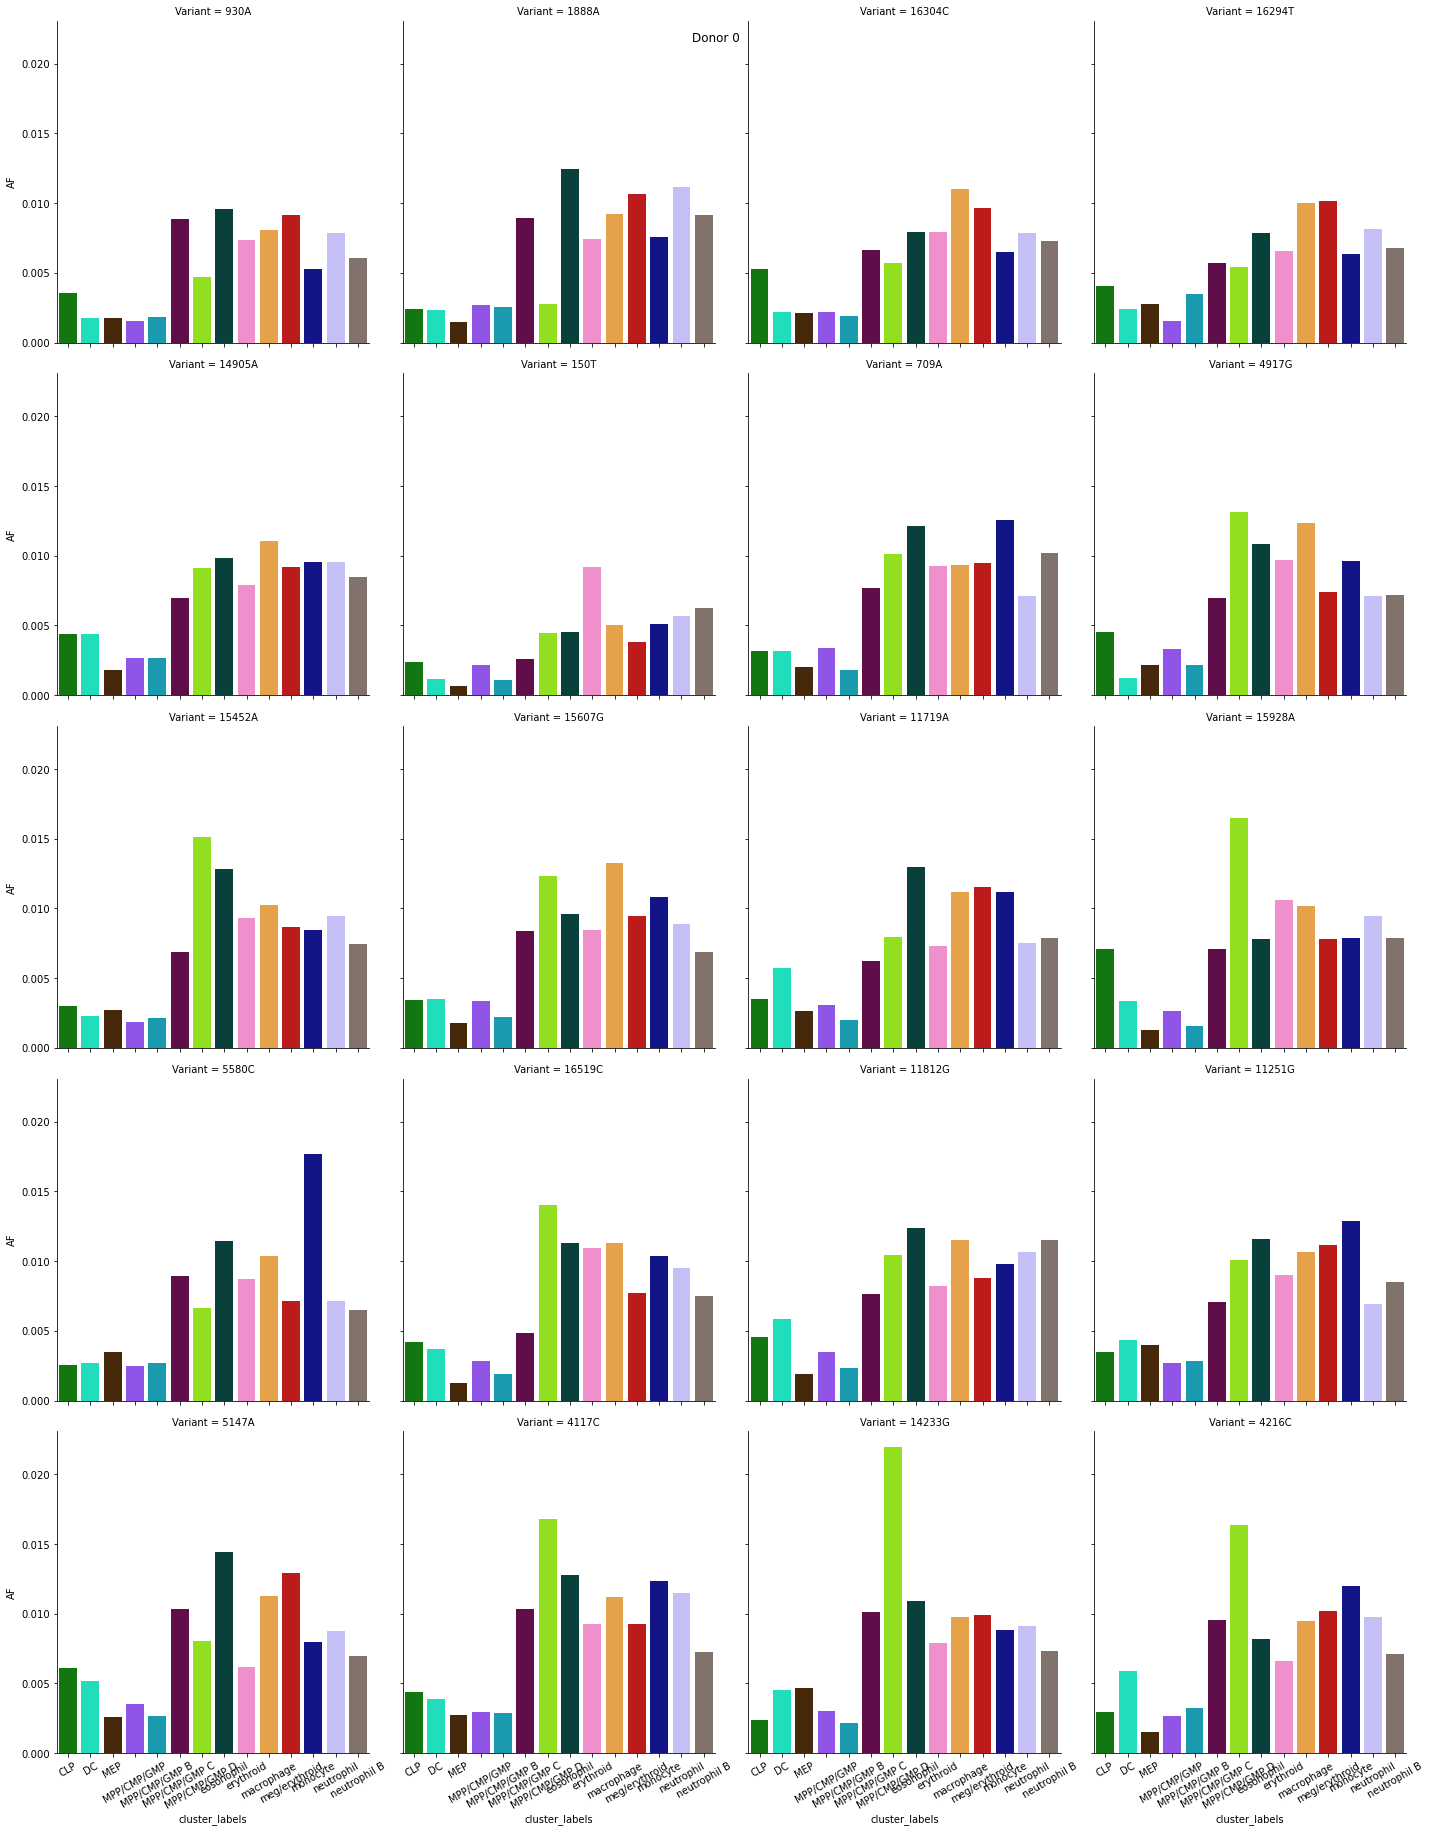

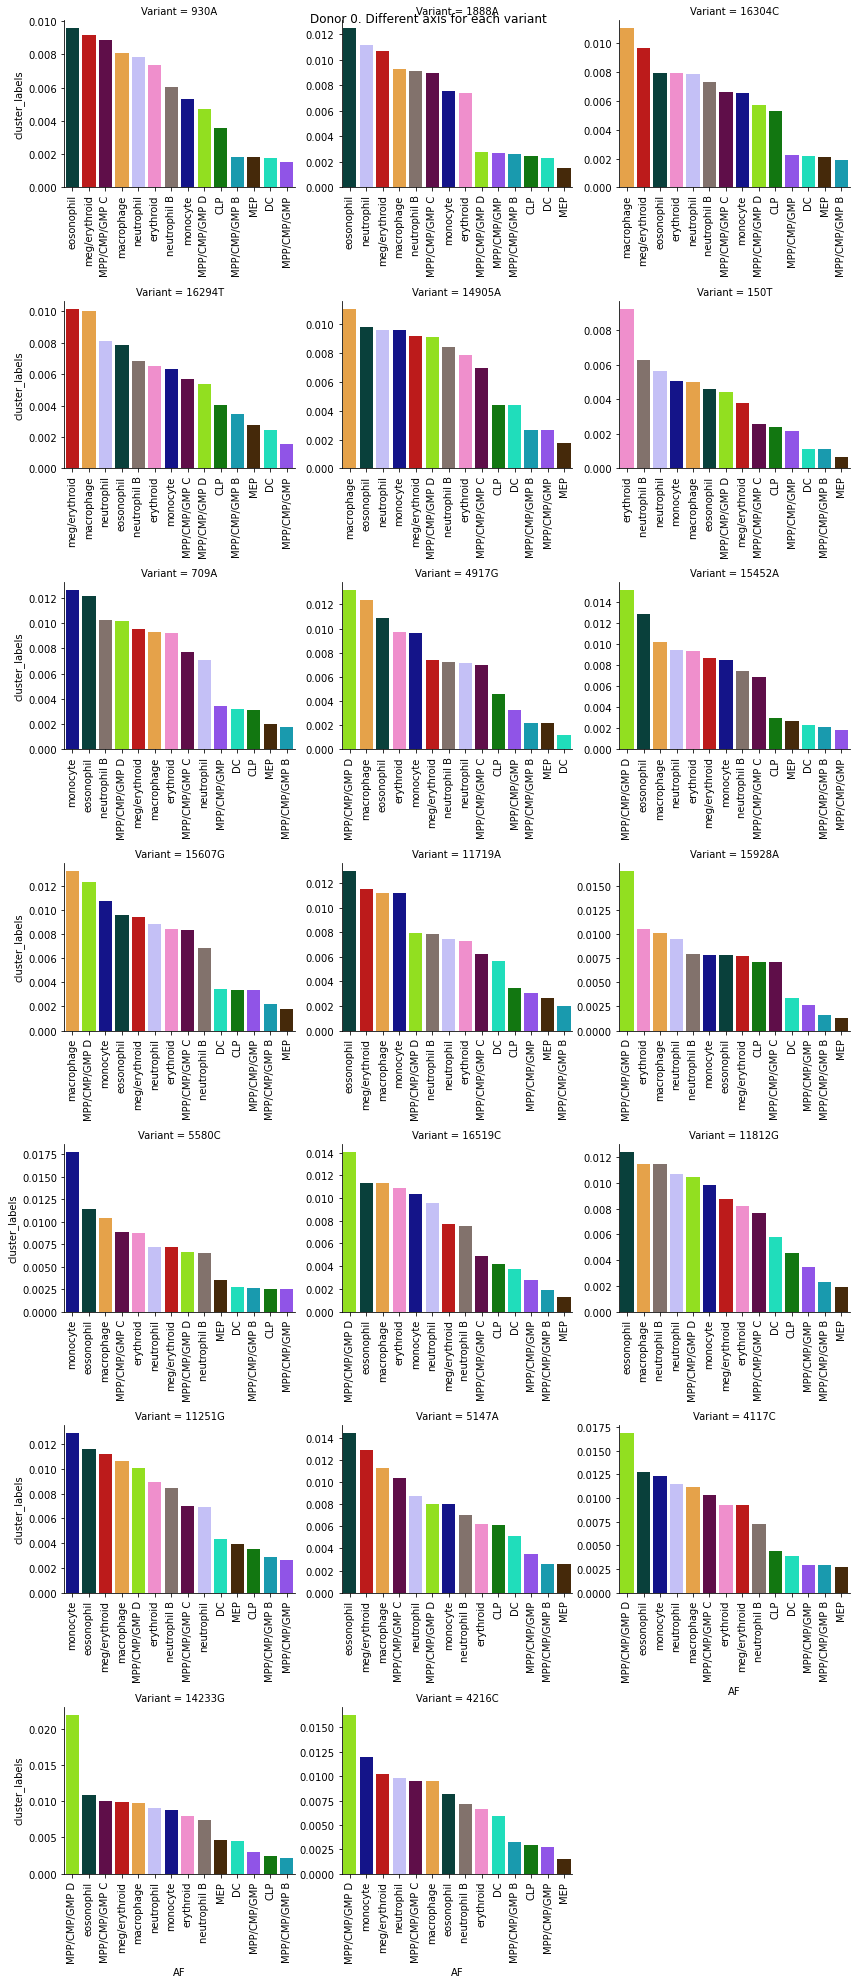

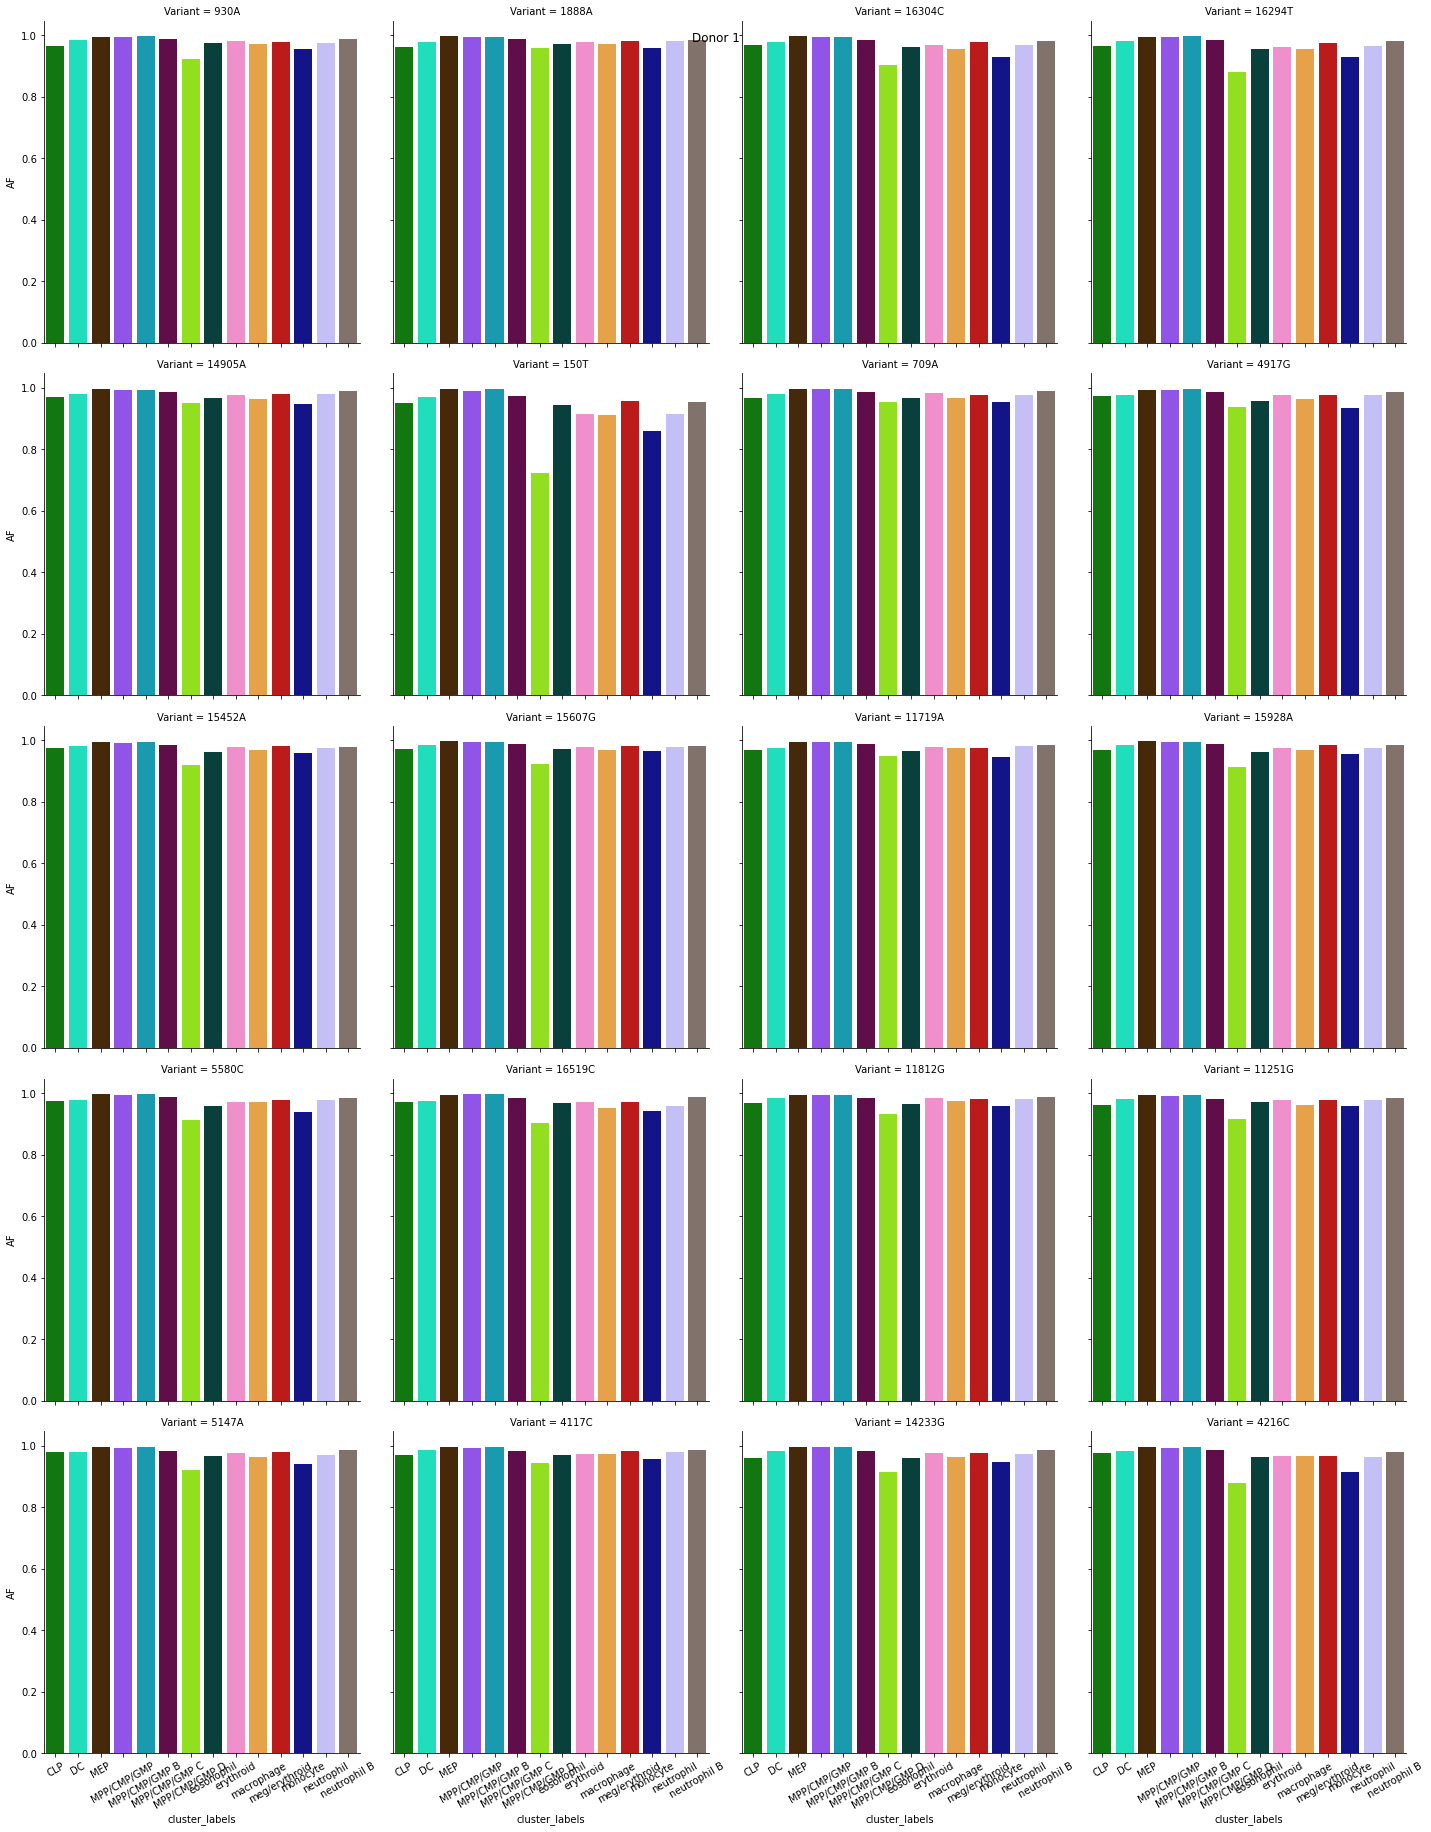

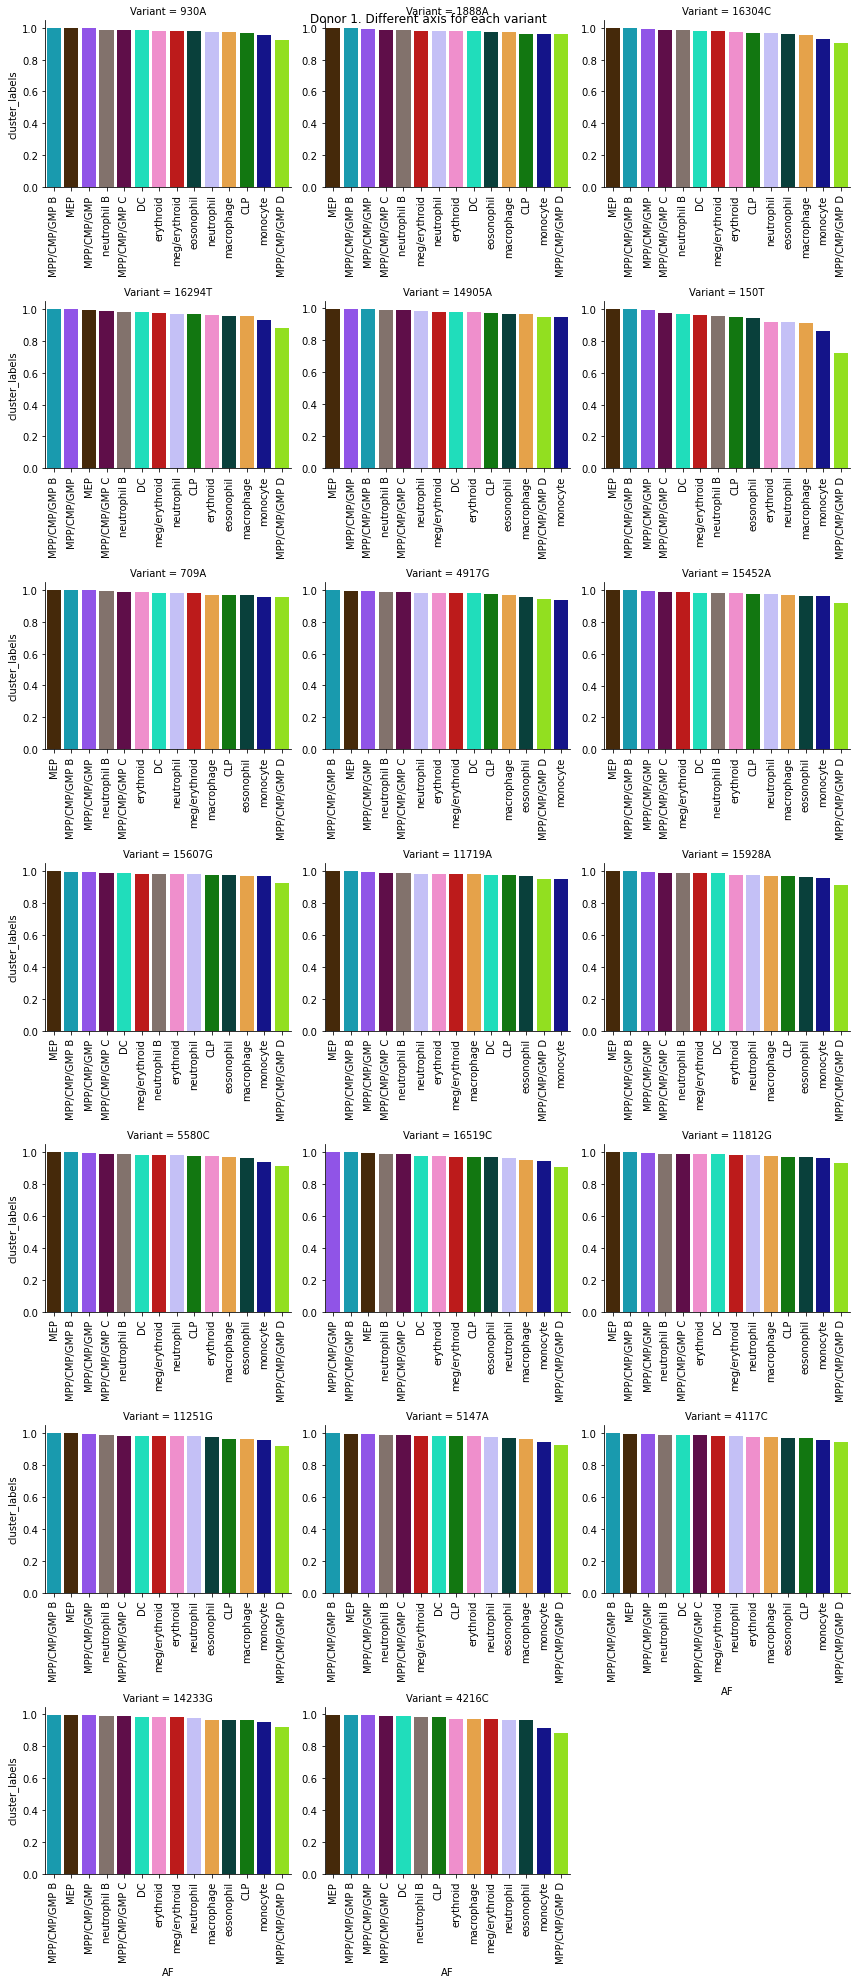

In [14]:
# def get_cv(x):
#     return np.std(x, ddof=1) #/ np.mean(x) * 100

# lin_mt_cv = (lin_mt_af).apply(get_cv, axis=0).sort_values(ascending=False)
# lin_mt_af = lin_mt_af.loc[:,lin_mt_cv.index]

# lin_mt_af_w = lin_mt_af.iloc[:,:20].reset_index().melt(id_vars=["cluster_labels", "donor"], var_name="Variant", value_name="AF")
# lin_mt_af_w

# hue_order = lin_mt_af_w["cluster_labels"].unique()
# color_out = create_color_df_v02(lin_mt_af_w, col="cluster_labels", clr_type='categorical')

# def order_bar(af, cluster_labels, **kwargs):
#     df = pd.DataFrame({"AF":af, "clust": cluster_labels}) #, columns=['AF',"clust"])
#     order = cluster_labels.loc[af.sort_values(ascending=False).index] #by="AF", ascending=False)["cluster_labels"]
#     #print(df)
#     #sns.barplot(data=df, y="AF", x="clust", order=order, hue="clust", hue_order=hue_order)
#     sns.barplot(y=af, x=cluster_labels, order=order, hue=cluster_labels, palette=color_out[2],dodge=False)#, hue_order=hue_order)
#     #plt.xticks(rotation=45)
#     return



# for curr_don, don_af in lin_mt_af_w.groupby("donor"):
#     g = sns.catplot(x="cluster_labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
#                     hue_order=hue_order, palette=color_out[2])
#     g.set_xticklabels(rotation=30)
#     g.fig.suptitle(f"Donor {curr_don}")
    
    
# #    g = sns.catplot(x="cluster_labels", y="AF", col="Variant", kind='bar', data=don_af, col_wrap=4, 
#  #               sharey=False, sharex=False, hue=None)
#     g = sns.FacetGrid(col="Variant", data=don_af, col_wrap=3, sharex=False, sharey=False, 
#                       hue_order=hue_order,height=4)
#     g.map(order_bar, "AF", "cluster_labels")
#     g.set_xticklabels(rotation=90)
#     g.fig.suptitle(f"Donor {curr_don}. Different axis for each variant")
#     g.fig.tight_layout()

In [ ]:
## Informative variants function
#af	oth_af	ncells	oth_ncells	mean_cov	cov	oth_cov
def get_vars(thresholds, position_af, position_cov):
    """ Sees if current position is an 'informative' variant using current thresholds
    """
    # preprocess some thresholds
    if thresholds["ncells"] < 1:
        ncells = int(np.floor(thresholds["ncells"] * len(position_af)))
    else:
        ncells = thresholds["ncells"]
    if thresholds["oth_ncells"] < 1:
        oth_ncells = int(np.floor(thresholds["oth_ncells"] * len(position_af)))
    else:
        oth_ncells = thresholds["oth_ncells"]    

    # Get cells that pass af and coverage thresholds
    bin_position_af_cov = (position_af > thresholds["af"]) & (position_cov > thresholds["cov"])
    #print('bin_pos', bin_position_af_cov)
    #print(bin_position_af_cov.sum())
    
    oth_bin_position_af_cov = (position_af <= thresholds["oth_af"]) & (position_cov > thresholds["oth_cov"])
    
    if (bin_position_af_cov.sum() > ncells) & (oth_bin_position_af_cov.sum() > oth_ncells):
        return True
    
    return False

def run_per_pos(af_cov, thresholds ,cov_id="COV-"):
    split = int(af_cov.shape[0]/2)
    af = af_cov.iloc[:split]
    cov = af_cov.iloc[split:]

    cov.index = [x.split(cov_id,1)[1] for x in cov.index]
    thresholds['isVar'] = thresholds.apply(get_vars, args=(af, cov), axis=1)
    thresholds["var"] = af_cov.name
    return thresholds


## Plot 
def plots(params_results, outdir, prefix):
    sns.histplot(params_results["n_vars"])

    cov_groups = params_results.groupby(["cov", "oth_cov", "mean_cov"])

    for ind, val in cov_groups:
        print(ind)
        sns.catplot(data=val, y="n_vars", x= "ncells", 
                    hue="af", row="oth_af", col="oth_ncells", kind="bar")
        plt.suptitle(f"{prefix} cov {ind[0]} oth_cov {ind[1]} mean_cov {ind[2]}")
        plt.tight_layout()
        plt.savefig(join(outdir,f"{prefix}_nvars_thresholds.cov_{ind[0]}_othcov_{ind[1]}_mean_{ind[2]}.png"))
    return

## Check subset variants

In [ ]:
params_results

## For each pairwise variants check if the cells with the variant (and coverage) is over 50%, if it is remove the smaller one (create tree)